<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab1/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Logistic Regression

In this lab, we will be creating a binary classifier using Logistic Regression first implemented using Numpy and then using Tensorflow. The classifier has to be trained on the `notMNIST` dataset, and particularly classify only between the letters `C` (positive class, labelled `1`) and `J` (negative class, labelled `0`). This dataset, representing the ground truth, will be represented as $\mathcal{D}= \{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where there are $N$ datavectors $\mathbf{x}_i \in \mathbb{R}^d$ and labels $y_i \in \{0, 1\}$.

## 1. Logistic Regression with Numpy

We use the following model for computing the probability of a datavector $\mathbf{x}_n\in\mathbb{R}^d$ belonging to a particular class $y_n\in \{0, 1\}$:

$$\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n) = \sigma\left((2y_n-1)(\mathbf{w}^\top\mathbf{x}_n + b)\right),$$

given the model parameters $\mathbf{w} \in \mathbb{R}^d$ (wieght) and $b \in \mathbb{R}$ (bias), and the logistic (or sigmoid) function $\sigma(z) = \frac{1}{1+e^{-z}}$.

However, to simply expressions we will augment our datavectors $\mathbf{x}_i$ with ones and accordingly increment the dimension of the weightvector, such that $\mathbf{x}_i = \begin{bmatrix}1 & x_1 & \ldots & x_d\end{bmatrix} \in \mathbb{R}^{d+1}$ and $\mathbf{w} = \begin{bmatrix}b & w_1 & \ldots & w_d \end{bmatrix}\in \mathbb{R}^{d+1}$. This will yield the (binary) label prediction probability to be:

$$\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n) = \sigma\left((2y_n-1)(\mathbf{w}^\top\mathbf{x}_n)\right).$$
No changes are made to the label sequence $y_i$. Also note that the corresponding changes to function signatures were made, so the functions defined in this document (e.g. `loss` and `grad_loss`) will differ slightly from the lab handout.

### 1.1 Loss Function and Gradient 

We will use the regularized loss function (in-sample error) for minimization while training over the dataset:

$$\begin{align*}
E_{\text{in}, \lambda}(\mathbf{w}) &= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N -\log\left(\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n)\right)\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[-I(y_n=1)\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -I(y_n=0)\log(\hat{p}_\mathbf{w}(0\mid \mathbf{x}_n))\big] \quad \triangleright \text{since } y_n \text{ only has two possibilities}\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[-y_n\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -(1-y_n)\log(1-\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n))\big]\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[y_n\log(1 + e^{-\mathbf{w}^\top\mathbf{x}_n})) +(1-y_n)\log(1+e^{\mathbf{w}^\top\mathbf{x}_n})\big],
\end{align*}
$$
where $\lambda > 0$ is the regularization constant and $I(p)$ is the identifier function defined to be, $I(p) = \begin{cases}1 & \text{predicate } p \text{ is true}\\ 0 & \text{predicate } p \text{ is false}\end{cases}$

The gradient of the loss function is:

$$
\begin{align*}
∇_{\mathbf{w}}E_{\text{in}, \lambda}(\mathbf{w}) &= ∇_{\mathbf{w}}\lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N ∇_{\mathbf{w}}\big[-y_n\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -(1-y_n)\log(1-\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n))\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N\big[-y_n(1+e^{-\mathbf{w}^\top\mathbf{x}_n})∇_{\mathbf{w}}(1+e^{-\mathbf{w}^\top\mathbf{x}_n})^{-1}-(1-y_n)(1+e^{\mathbf{w}^\top\mathbf{x}_n})∇_{\mathbf{w}}(1+e^{\mathbf{w}^\top\mathbf{x}_n})^{-1}\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N\big[-y_n\mathbf{x}_n\underbrace{\frac{e^{-\mathbf{w}^\top\mathbf{x}_n}}{(1+e^{-\mathbf{w}^\top\mathbf{x}_n})}}_{\sigma(-\mathbf{w}^\top\mathbf{x}_n) = 1-\sigma(\mathbf{w}^\top\mathbf{x}_n)}+(1-y_n)\mathbf{x}_n\underbrace{\frac{e^{\mathbf{w}^\top\mathbf{x}_n}}{(1+e^{\mathbf{w}^\top\mathbf{x}_n})}}_{\sigma(\mathbf{w}^\top\mathbf{x}_n)}\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N \mathbf{x}_n\left(\sigma(\mathbf{w}^\top\mathbf{x}_n)-y_n\right)\\
&=2\lambda\mathbf{w} + \frac{1}{N}\mathbf{X}^\top\left(\boldsymbol{\sigma}(\mathbf{X}\mathbf{w})-\mathbf{y}\right), 
\end{align*}
$$

where $\mathbf{X} = \begin{bmatrix}\mathbf{x}_1^\top\\\vdots\\\mathbf{x}_N^\top\end{bmatrix}\in \mathbb{R}^{N\times(d+1)}$ is the datamatrix, $\mathbf{y} \in \{0,1\}^{N}$ is the labelvector, and $\boldsymbol{\sigma}(\cdot)$ is a vector function acting element-wise on the input vector by applying the (scalar) logistic function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))

In [3]:
def loss(w, X, ys, reg_lambda):
    Xw = X @ w
    logit_CE_loss = ys*np.log(1 + np.exp(-Xw)) + (1 - ys)*np.log(1 + np.exp(Xw))
    # return regularization penalty + cross entropy loss
    return reg_lambda*np.linalg.norm(w)**2 + np.mean(logit_CE_loss)

In [4]:
def grad_loss(w, X, ys, reg_lambda):
    return 2*reg_lambda*w + 1/X.shape[0]*(X.T @ (sigmoid(X@w) - ys))

### 1.2 Gradient Descent Implementation

The update step is:

$$\mathbf{w}_{k+1} = \mathbf{w}_k - ϵ\underbrace{∇_{\mathbf{w}}E_{\text{in}, λ}(\mathbf{w}_k)}_{\texttt{grad_loss}(\mathbf{w}_k)},$$

where $ϵ > 0$ is the learning rate.

In [5]:
def grad_descent(w, X, ys, eps, epochs, reg_lambda, error_tol=1e-7):
    w_opt     = np.copy(w)
    loss_hist = []
    for i in range(epochs):
        grad_w = grad_loss(w, X, ys, reg_lambda)
        w_opt  = w - eps*grad_w
        if np.linalg.norm(w-w_opt)**2 < error_tol:
            break
        else:
            w = w_opt
        loss_hist.append(loss(w, X, ys, reg_lambda))
    return w_opt, loss_hist

Now we will test it on the data. The `notMNIST` dataset has images of size $28\times 28$, thus we have $d=784$. 

In [6]:
# load data
def loadDataGDrive():
    with np.load('/content/drive/MyDrive/Colab Notebooks/notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

x_train, x_valid, x_test, ys_train, ys_valid, ys_test = loadDataGDrive()

In [7]:
# augment datavectors
X_train = np.concatenate([np.ones((x_train.shape[0])).reshape(-1, 1), x_train.reshape(x_train.shape[0], -1)], axis=1)
X_valid = np.concatenate([np.ones((x_valid.shape[0])).reshape(-1, 1), x_valid.reshape(x_valid.shape[0], -1)], axis=1)
X_test  = np.concatenate([np.ones((x_test.shape[0])).reshape(-1, 1), x_test.reshape(x_test.shape[0], -1)], axis=1)

In [8]:
# run grad_desc (output optimal things)
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1))
w_star, loss_history = grad_descent(w_init, X_train, ys_train, 0.005, 10000, 0)

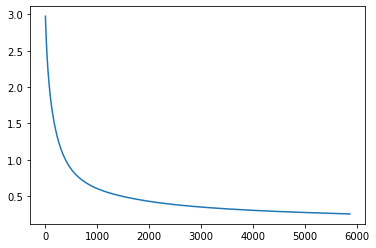

In [9]:
plt.plot(loss_history)

### 1.3 Tuning the Learning Rate

### 1.4 Generalization


## 2. Logistic Regression in TensorFlow
